# Phishing Detection Using Neural Networks <br> Combined With Adversarial Synthesized Data

## Katherine Haynes <br> Fall, 2020


# 1 Setup

In [1]:
useGoogle = False

### Load Libraries

In [2]:
# Load Libraries
from functools import partial
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time

from hyperopt import fmin, hp, Trials, tpe, space_eval, STATUS_OK
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

In [3]:
# Set Data Locations
if useGoogle:
    from google.colab import drive
    drive.mount('/content/drive')
    dirIn = '/content/drive/My Drive/cs533/' 

    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print('Using GPU!')
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

else:
    dirIn = '../'

In [69]:
# Set Plotting Sizes
TINY_SIZE = 12
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
HUGE_SIZE = 24

plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)    # legend fontsize

In [5]:
# Set Plotting Colors
myColors = ['darkblue','slateblue','darkviolet','fuchsia','crimson',
            'orangered','goldenrod','darkolivegreen','darkslategrey']
myColorsCB=['slategray','cornflowerblue','royalblue','midnightblue',
            'slateblue','mediumslateblue','rebeccapurple','blueviolet',
            'mediumorchid','plum','fuchsia','orchid','hotpink']

mpl.rcParams['figure.figsize'] = (12, 10)
AllColors = ['#004C99','#0066CC','#0080FF','#3399FF',
             '#4C0099','#6600CC','#7F00FF','#9933FF',
             '#660066','#990099','#CC00CC','#FF00FF']
AllColorsSamePurple = ['#004C99','#004C99','#004C99','#004C99',
                 '#4C0099','#4C0099','#4C0099','#4C0099',
                 '#660066','#660066','#660066','#660066']
AllColorsSame2 = ['#377eb8','#377eb8','#377eb8','#377eb8',
                 '#e41a1c','#e41a1c','#e41a1c','#e41a1c',
                 '#4daf4a','#4daf4a','#4daf4a','#4daf4a']
aCol='tab:blue'
bCol='tab:red'
cCol='tab:orange'
dCol='tab:green'
AllColorsSame = [aCol,aCol,aCol,aCol,
                 bCol,bCol,bCol,bCol,
                 cCol,cCol,cCol,cCol]

colorTOTO = 'tab:blue'
colorTOTS = 'tab:red'
colorTOSTO = 'tab:orange'
colorTOSTS = 'tab:green'
colorTOSTOS = 'tab:purple'

In [6]:
# Function to determine if a variable is defined
def exists(var):
    var_exists = var in locals() or var in globals()
    return var_exists

# 2 Data

### Define Data Functions

In [7]:
# Function to read in original data
def read_data():
    
    filedir = dirIn + 'data/'
    fileOrig = filedir + 'DS4-Original.csv'
    
    nCols=49
    allCols1 = range(19)
    allCols2 = range(20,nCols-1)
    allCols = itertools.chain(allCols1,allCols2)
    with open(fileOrig) as f:
        firstline = f.readline()
    origNamesBad = firstline.split(",")
    origNames = []
    origIndices = []
    for i in allCols:
        origNames.append(origNamesBad[i])
        origIndices.append(i)

    origData = np.genfromtxt(fileOrig, delimiter=',',skip_header=1,
                         usecols=origIndices)
    origYNeg = np.genfromtxt(fileOrig, delimiter=',',skip_header=1,
                         usecols=(nCols-1))
    
    nData = origYNeg.shape[0]
    origY = np.zeros(nData,dtype=int)
    phishRefs = np.where(origYNeg == 1)
    legitRefs = np.where(origYNeg == -1)
    origY[phishRefs] = 1

    return origData, origY, origNames

In [8]:
# Function to read in synthetic data
def read_syn():
    
    filedir = dirIn + 'data/'
    filePhish = filedir + 'DS4-Phishing-Generated.csv'
    fileLegit = filedir + 'DS4-Legitimate-Generated.csv'
    
    phishData = np.genfromtxt(filePhish, delimiter=',',skip_header=1)
    legitData = np.genfromtxt(fileLegit, delimiter=',',skip_header=1)
 
    nPhish = phishData.shape[0]
    nLegit = legitData.shape[0]
    nSyn = nPhish+nLegit
    nAttsPhish = phishData.shape[1]
    nAttsLegit = legitData.shape[1]
    if nAttsPhish != nAttsLegit:
        print('!!!Number of Attributes Different Between \
               Phishing/Legit Data!!!')
    else:
        nAtts = nAttsPhish

    XSyn = np.zeros((nSyn,nAtts))
    XSyn[0:nPhish,:] = phishData[:,:]
    XSyn[nPhish:,:] = legitData[:,:]
    
    YSyn = np.zeros(nSyn,dtype=int)        
    YSyn[0:nPhish] = 1
    
    return XSyn, YSyn

In [9]:
# Function to shuffle two arrays
def shuffle_XY(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

### Open and Read Original Data Set

In [10]:
readOrigData = False
plotOrigDist = True
plotDistFeatNum = 36

In [11]:
# Open and Read the Original Data Set
if readOrigData:
    Xall, Yall, featNames = read_data()
    neg, pos = np.bincount(Yall)
    total = neg + pos
    print('   Total Original Samples: {}, Positive: {} ({:.2f}%)'.format(total, pos, 100*pos/total))

In [12]:
# Plot Feature Distributions
if readOrigData and plotOrigDist: 
    gRef = np.where(Yall == 0)
    Ygood = Yall[gRef]
    Xgood = Xall[gRef,plotDistFeatNum]
    histNums, histOut = np.unique(Xgood,return_counts=True)
    plt.figure(figsize=(14,8))
    plt.subplot(1, 2, 1)
    plt.bar(histNums, histOut)
    myTitle = featNames[plotDistFeatNum] + ' Legitimate'
    plt.title(myTitle)

    bRef = np.where(Yall == 1)
    Ybad = Yall[bRef]
    Xbad = Xall[bRef,plotDistFeatNum]
    plt.subplot(1, 2, 2)
    plt.bar(histNums, histOut)
    myTitle = featNames[plotDistFeatNum] + ' Legitimate'
    histNums, histOut = np.unique(Xbad,return_counts=True)
    plt.bar(histNums, histOut)
    myTitle = featNames[plotDistFeatNum] + ' Phishing'
    plt.title(myTitle)

### Open and Read Synthetic Data Set

In [13]:
readSynData = False
plotSynDist = False

In [14]:
# Open and Read the Synthetic Data Set
if readSynData:
    XSyn, YSyn = read_syn()
    negSyn, posSyn = np.bincount(YSyn)
    totalSyn = negSyn + posSyn
    print('    Total Synthetic Samples: {}, Positive: {} ({:.2f}%)'.format(totalSyn, posSyn, 100*posSyn/totalSyn))

In [15]:
# Plot Feature Distributions
if plotSynDist: 
    histNums, histOut = np.unique(XSyn[:,plotDistFeatNum],return_counts=True)
    plt.bar(histNums, histOut)
    plt.title(featNames[plotDistFeatNum])
    plt.ylabel('Number')

### Determine Attribute Importance Ordering
Use univariate feature selection to determine which attributes to include when selecting features.  Creates a dictionary saved into a pickle file that can be read during training and testing to ensure the same variables are selected for training/testing despite different variable importance that may occur from the random sampling for training/testing distributions.  Uses only the original dataset to select the variables, and saves the variables to use for using 2 to 47 attributes.  This is necessary because the model optimization includes a selection of the number of attributes in order to obtain the best results.

In [16]:
saveVarXRef = False
fileVarXRef = dirIn + 'data/cat/varXRefSyn.pkl'

In [17]:
if saveVarXRef:
    # To use syn data:
    # XAll = XSyn
    # YAll = YSyn
    varList = {}
    varXRef = {}
    nFeatures = len(featNames)

    for i in range(2,nFeatures+1):
        mySelect = SelectKBest(f_classif, k=i)
        XAtt_ = mySelect.fit_transform(XAll, YAll)
        xRef = mySelect.get_support()
        varXRef[i] = xRef
        uNames = [featNames[x] for x in range(nFeatures) if xRef[x] == True]
        varList[i] = uNames
        
    with open(fileVarXRef, 'wb') as handle:
          pickle.dump([varXRef, varList],
                       handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('Created File: ',fileVarXRef)

### Split Data into Training and Testing

For this study, I used 80% of the data for training and 20% for testing.

In [18]:
splitData = False
shuffleData = True
testFrac = 0.2

saveDataOrig = False
fileSplitOrig = dirIn + 'data/splitOrig.pkl'

saveDataSyn = False
fileSplitSyn = dirIn + 'data/splitSyn.pkl'

In [19]:
# Make a train/test split of original data
if splitData and readOrigData:
    XTrain, XTest, YTrain, YTest = \
        train_test_split(Xall, Yall, test_size=testFrac, shuffle=shuffleData)
       
    uniqueTrain, countTrain = np.unique(YTrain, return_counts=True)
    uniqueTest, countTest = np.unique(YTest, return_counts=True)
    np.set_printoptions(precision=3)
    print('Train Orig Dist: ',countTrain/np.sum(countTrain),np.sum(countTrain))
    print('Test Orig Dist : ',countTest/np.sum(countTest),np.sum(countTest))
    if saveDataOrig:
        with open(fileSplitOrig, 'wb') as handle:
            pickle.dump([XTest, YTest, XTrain, YTrain], 
                         handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# Make a train/test split of synthetic data
if splitData and readSynData:
    XSynTrain, XSynTest, YSynTrain, YSynTest = \
        train_test_split(XSyn, YSyn, test_size=testFrac, shuffle=shuffleData)
       
    uniqueSynTrain, countSynTrain = np.unique(YSynTrain, return_counts=True)
    uniqueSynTest, countSynTest = np.unique(YSynTest, return_counts=True)
    np.set_printoptions(precision=3)
    print('Train Syn Dist: ',countSynTrain/np.sum(countSynTrain),np.sum(countSynTrain))
    print('Test Syn Dist : ',countSynTest/np.sum(countSynTest),np.sum(countSynTest))
    if saveDataSyn:
        with open(fileSplitSyn, 'wb') as handle:
            pickle.dump([XSynTest, YSynTest, XSynTrain, YSynTrain],
                         handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load Saved Training/Testing Data

In [38]:
loadOrigData = True
fileOrigData = dirIn + 'data/cat/splitOrig.pkl'

loadSynData = True
fileSynData = dirIn + 'data/cat/splitSyn.pkl'

In [39]:
# Load original training/testing data:
if loadOrigData:
    with open(fileOrigData,'rb') as handle:
        allTemp = pickle.load(handle)
    XTest = allTemp[0]
    YTest = allTemp[1]
    XTrain = allTemp[2]
    YTrain = allTemp[3]
    del allTemp
    
    nTest = XTest.shape[0]
    nTrain = XTrain.shape[0]
    print('    Original Samples Training: {}, Testing: {}'.format(nTrain, nTest))

    Original Samples Training: 8000, Testing: 2000


In [40]:
# Load synthetic training/testing data:
if loadSynData:
    with open(fileSynData,'rb') as handle:
        allTemp = pickle.load(handle)
    XSynTest = allTemp[0]
    YSynTest = allTemp[1]
    XSynTrain = allTemp[2]
    YSynTrain = allTemp[3]
    del allTemp
    
    nSynTest = XSynTest.shape[0]
    nSynTrain = XSynTrain.shape[0]
    print('    Synthetic Samples Training: {}, Testing: {}'.format(nSynTrain, nSynTest))

    Synthetic Samples Training: 16000, Testing: 4000


### Use Original or Synthetic Data

In [24]:
useSynOnly = False

In [25]:
if useSynOnly:
    XTrain = XSynTrain
    XTest = XSynTest
    YTrain = YSynTrain
    YTest = YSynTest

# 3 Neural Network Hyper-Parameter Search Space


### Network Architecture Features 
Architecture features are options associated with the neural network setup. <br>
This search space consists of two elements:

* <b>Dropout Rate</b><br>
Use a uniform distribution in finding an appropriate dropout value. <br>
hp.uniform('dropout', 0.0, 0.4) <br>

* <b>Number of Dense Layers</b><br>
Determine the number of hidden dense layers, ranging from 1 to 8.
hp.choice('ndense', range(8)) <br>

### Network Parameters
Parameters are options associated with the nueral network implementation. <br>
This search space consists of six elements:

* <b>Activation</b><br>
Select from three different activation types: exponential, rectified linear unit, and hyperbolic tangent.<br>
hp.choice('activation', ['elu','relu','tanh']) <br><br>

* <b>Batch Size</b><br>
Vary the batch size fed for each gradient update from 100 to 700, incrementing by 5.<br>
hp.quniform('batch_size', 100, 700, 5)<br><br>

* <b>Beta 1</b><br>
Vary the exponential decay rate for the 1st moment estimates, ranging from 0.8 to 1.0.<br>
hp.uniform('beta_1', 0.8, 1.0)<br><br>

* <b>Beta 2</b><br>
Vary the exponential decay rate for the 2nd moment estimates, ranging from 0.9 to 1.0.<br>
hp.uniform('beta_2', 0.9, 1.0)<br><br>

* <b>Learning Rate</b><br>
Use a loguniform scale to make it vary exponentially in a multiplicative fashion. <br>
hp.loguniform('lr_rate', -0.5, 0.5) <br><br>

* <b>Initial Accumulator Value</b><br>
Vary the initial accumulator value for the Adagrad optimizer using a multiplier on the default value of 0.1.
hp.loguniform('iacc_mult', -0.2, 0.2)<br><br>

* <b>Number of Epochs</b><br>
Vary the number of epochs for training, ranging from 10 to 200.<br>
hp.choice('nepochs', [10,20,40,60,80,100,120,150,200])<br><br>

* <b>Number of Hidden Units</b><br>
Vary the number of hidden units from 8 to 200, specifying the range per dense layer.  The overarching approach is to initially increase the range and number of hidden units and then decrease towards the maximum number of layers. <br>
hp.choice('nhidden', range(8,200) <br><br>

* <b>Optimizer</b><br>
Select from four different optimizer options: Adagrad, Adam, NAdam, and SCG. <br>
hp.choice('optimizer', ['Adagrad','Adam','Nadam','SCG']) <br>



## Search Method: [Hyperopt](http://jaberg.github.io/hyperopt/)
The data pre-processing, network building components, and model parameters will be searched using [Hyperopt](http://proceedings.mlr.press/v28/bergstra13.pdf).


## Search Evaluation
I will use both a train/test split and cross-validation to evaluate my models.  The hyperparameter optimization will be conducted on the training split; however, to find the best options and avoid overfitting I will use 3-fold cross-validation in the parameter searches.  Once the optimal options and parameters have been found using the training dataset, the final model selection will be based on model performance for the testing split.  The top ten models from a guided search on the training data (using cross-validation) will then be evaluated on the hold-out testing data for final model recommendations.

## Search Definition

In [26]:
# SEARCH SPACE DEFINITION
if not exists('nVars'):
    nVars = 47
space = {
    'normalize': hp.choice('normalize', ['True','False']),
    'n_features': hp.choice('nfeatures', range(2,nVars)),
    'batch_size': hp.quniform('batch_size', 100, 600, 5),
    'nepochs': hp.choice('nepochs', [10,20,40,60,80,100,120,150,200]),
    'ndense': hp.choice('ndense', range(2,10)),
    'activation1': hp.choice('activation1', ['elu','relu','tanh']),
    'activation2': hp.choice('activation2', ['elu','relu','tanh']),
    'activation3': hp.choice('activation3', ['elu','relu','tanh']),
    'activation4': hp.choice('activation4', ['elu','relu','tanh']),
    'activation5': hp.choice('activation5', ['elu','relu','tanh']),
    'activation6': hp.choice('activation6', ['elu','relu','tanh']),
    'activation7': hp.choice('activation7', ['elu','relu','tanh']),
    'activation8': hp.choice('activation8', ['elu','relu','tanh']),
    'activation9': hp.choice('activation9', ['elu','relu','tanh']),
    'activation10': hp.choice('activation10', ['elu','relu','tanh']),
    'dropout2': hp.uniform('dropout2', 0.0, 0.3),
    'dropout3': hp.uniform('dropout3', 0.0, 0.3),
    'dropout4': hp.uniform('dropout4', 0.0, 0.3),
    'dropout5': hp.uniform('dropout5', 0.0, 0.3),
    'dropout6': hp.uniform('dropout6', 0.0, 0.3),
    'dropout7': hp.uniform('dropout7', 0.0, 0.3),
    'dropout8': hp.uniform('dropout8', 0.0, 0.3),
    'dropout9': hp.uniform('dropout9', 0.0, 0.3),
    'nunits1': hp.choice('nunits1', range(8,40)),
    'nunits2': hp.choice('nunits2', range(20,80)),
    'nunits3': hp.choice('nunits3', range(60,120)),
    'nunits4': hp.choice('nunits4', range(100,200)),
    'nunits5': hp.choice('nunits5', range(60,120)),
    'nunits6': hp.choice('nunits6', range(40,120)),
    'nunits7': hp.choice('nunits7', range(30,100)),
    'nunits8': hp.choice('nunits8', range(20,80)),
    'nunits9': hp.choice('nunits9', range(10,60)),
    'optimizer': hp.choice('optimizer', ['Adagrad','Adam','Nadam','SGD']),
    'beta_1': hp.uniform('beta_1', 0.8, 1.0),
    'beta_2': hp.uniform('beta_2', 0.9, 1.0),
    'iacc_mult': hp.loguniform('iacc_mult', -0.2, 0.2),
    'lr_mult': hp.loguniform('lr_mult', -0.5, 0.5),
    'momentum': hp.uniform('momentum', 0.0, 0.6)
}

# 4 Neural Network Model Setup

### Build Functions

In [22]:
# BUILD MODEL FUNCTION
def build_model(params, nFeatures=0, output_bias=None):

    METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
    
    # Setup bias
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    # Save information from params
    opt = params['optimizer']
    if opt == 'Adagrad':
        myOpt = tf.keras.optimizers.Adagrad(
                    learning_rate=params['lr_mult']*0.001,
                    initial_accumulator_value=params['iacc_mult']*0.1)
    elif opt == 'Adam':
        myOpt = tf.keras.optimizers.Adam(
                    learning_rate=params['lr_mult']*0.001, 
                    beta_1=params['beta_1'], beta_2=params['beta_2'])
    elif opt == 'Nadam':
        myOpt = tf.keras.optimizers.Nadam(
                    learning_rate=params['lr_mult']*0.001,
                    beta_1=params['beta_1'], beta_2=params['beta_2'])
    elif opt == 'SGD':
        myOpt = tf.keras.optimizers.SGD(
                    learning_rate=params['lr_mult']*0.01,
                    momentum=params['momentum'])
    else:
        print("UNKNOWN OPTIMIZER. STOPPING.")
        sys_exit()
    
    # Define model
    model = Sequential()
    if nFeatures == 0:
        model.add(Dense(params['nunits1'], activation=params['activation1']))
    else:
        model.add(Dense(params['nunits1'], activation=params['activation1'], 
                        input_shape=(nFeatures,)))
    
    myActivation = ['activation2','activation2','activation3','activation4',
                    'activation5','activation6','activation7','activation8',
                    'activation9']
    myDropOut = ['dropout2','dropout3','dropout4','dropout5','dropout6',
                 'dropout7','dropout8','dropout9']
    myHiddenUnits = ['nunits2','nunits3','nunits4','nunits5','nunits6',
                     'nunits7','nunits8','nunits9']
    nLayers = params['ndense']-1
    for i in range(nLayers):
        model.add(Dense(params[myHiddenUnits[i]], 
                        activation=params[myActivation[i]]))
        model.add(Dropout(params[myDropOut[i]]))
        
    model.add(Dense(1, activation='sigmoid', 
                    bias_initializer=output_bias))

    # Compile Model
    model.compile(optimizer=myOpt, loss='binary_crossentropy', 
                  metrics=METRICS)

    #model.summary()
    return model

In [23]:
# TRAIN MODEL FUNCTION
def train_model(params, X, Y, nCVSplits=3,
                output_bias=None, verbose=False):
      
    # Set the data
    y_ = Y[:]
    nEpochs = params['nepochs']
    sBatch = int(params['batch_size'])
    
    # Make pre-processing selections
    X_ = select_data(X, params)
    nFeatures = X_.shape[1]

    # Build the model
    model = build_model(params, nFeatures=nFeatures, output_bias=output_bias)
    if verbose:
        model.summary()

    # Train using cross-validation
    dCV = StratifiedKFold(n_splits=nCVSplits, shuffle=True)
    dCV_iter = dCV.split(X_, y_)
    history = {}
    for train_index, test_index in dCV_iter:
        x_train,x_test=X_[train_index],X_[test_index]
        y_train,y_test=y_[train_index],y_[test_index]
        histNow = model.fit(x_train, y_train, epochs=nEpochs, 
                            batch_size=sBatch, verbose=0,
                            validation_data=(x_test,y_test))
        
        for key, val in histNow.history.items():
            if key in history:
                tempL = history[key]
                count=0
                for vh in val:
                    tempL[count].append(vh)
                    count+=1
            else:
                tempL = []
                for vh in val:
                    tempL.append([vh])
                history[key] = tempL
        
    # Add balanced accuracy
    add_balAcc(history)
    add_f1Score(history)
        
    # Create mean and standard deviation of cv results
    myItems = list(history.items())
    for key, val in myItems:
        newMean = []
        newStd = []
        for i in range(nEpochs):
            newMean.append(np.mean(val[i]))
            newStd.append(np.std(val[i],ddof=1))
            
        history[key] = newMean
        newKey = key + '_std'
        history[newKey] = newStd
    history['epoch'] = np.arange(1,nEpochs+1)
    
    # Clean up environment
    del model
    tf.keras.backend.clear_session()
    
    return history

In [42]:
# TEST MODEL FUNCTION
def test_model(params, XTrain, YTrain,
                  XTest, YTest, nCVSplits=3,
                  output_bias=None, verbose=False,
                  YPrint=False, YConf=False, 
                  YConfTitle=None,YConfSave=None):

    # Set the data
    y_ = YTrain[:]
    yTest_ = YTest[:]
    nEpochs = params['nepochs']
    sBatch = int(params['batch_size'])
    
    # Make pre-processing selections
    X_  = select_data(XTrain, params)
    XTest_ = select_data(XTest, params)
    nFeatures = X_.shape[1]

    # Build the model
    model = build_model(params, nFeatures=nFeatures, output_bias=output_bias)
    if verbose:
        model.summary()
        
    # Train using cross-validation
    dCV = StratifiedKFold(n_splits=nCVSplits, shuffle=True)
    dCV_iter = dCV.split(X_, y_)
    history = {}
    for train_index, test_index in dCV_iter:
        x_train,x_test=X_[train_index],X_[test_index]
        y_train,y_test=y_[train_index],y_[test_index]
        histNow = model.fit(x_train, y_train, epochs=nEpochs, 
                            batch_size=sBatch, verbose=0,
                            validation_data=(x_test,y_test))
        for key, val in histNow.history.items():
            if key in history:
                tempL = history[key]
                count=0
                for vh in val:
                    tempL[count].append(vh)
                    count+=1
            else:
                tempL = []
                for vh in val:
                    tempL.append([vh])
                history[key] = tempL
    
    # Add balanced accuracy to history
    add_balAcc(history)
    
    # Add f1 score to history
    add_f1Score(history)
    
    # Create mean and standard deviation of cv results
    myItems = list(history.items())
    for key, val in myItems:
        newMean = []
        newStd = []
        for i in range(nEpochs):
            newMean.append(np.mean(val[i]))
            newStd.append(np.std(val[i],ddof=1))
            
        history[key] = newMean
        newKey = key + '_std'
        history[newKey] = newStd
    history['epoch'] = np.arange(1,nEpochs+1)
    
    # Evaluate
    resultsList = model.evaluate(XTest_, yTest_, verbose=0)
    results = dict_Results(resultsList)
    add_balAcc(results)
    add_f1Score(results)
    
    # Make Precitions
    y_predict = (model.predict(XTest_) > 0.5).astype("int32")[:,0]
    if YPrint:
        nPhish = len(np.where(yTest_ == 1)[0])
        nLegit = len(np.where(yTest_ == 0)[0])
        nPhishP = len(np.where(y_predict == 1)[0])
        nLegitP = len(np.where(y_predict == 0)[0])
        nMis = len(np.where(y_predict != yTest_)[0])
        
        print("Number of Cases: {}".format(yTest_.shape[0]))
        print("  True Phish: {}, Predicted Phish: {}".format(nPhish, nPhishP))
        print("  True Legit: {}, Predicted Legit: {}".format(nLegit, nLegitP))
        print("  Number of Mismatches: {}".format(nMis))
    
    # Plot confusion matrix
    if YConf:
        tn, fp, fn, tp = confusion_matrix(yTest_, y_predict).ravel()
        cmatrix = np.array([[tp, fp],[fn, tn]])
        disp = plot_confusion_matrix(cmatrix, ['Phish','Legit'],
                                     cTitle=YConfTitle) 
        
        if YConfSave:
            plt.savefig(YConfSave,bbox_inches='tight')

    # Clean up environment
    del model
    tf.keras.backend.clear_session()
            
    return results, history, y_predict

### TPE Functions

In [25]:
# BALANCED ACCURACY FUNCTION
def add_balAcc(history):
    tp = np.array(history['tp'])
    fp = np.array(history['fp'])
    tn = np.array(history['tn'])
    fn = np.array(history['fn'])
    balAcc = ((tp/(tp+fn) + tn/(fp+tn))*0.5).tolist()
    history['balAcc'] = balAcc
    
    keyList = list(history.keys())
    if 'val_tp' in keyList:
        tp = np.array(history['val_tp'])
        fp = np.array(history['val_fp'])
        tn = np.array(history['val_tn'])
        fn = np.array(history['val_fn'])
        balAcc = ((tp/(tp+fn) + tn/(fp+tn))*0.5).tolist()
        history['val_balAcc'] = balAcc

In [26]:
# F1 SCORE FUNCTION
def add_f1Score(history):
    #tp = np.array(history['tp'])
    #fp = np.array(history['fp'])
    #fn = np.array(history['fn'])
    precision = np.array(history['precision'])
    recall = np.array(history['recall'])
    
    f1Score = 2*(precision*recall)/(precision+recall).tolist()
    #f1ScoreAlt = tp / (tp + 0.5*(fp+fn)).tolist()
    history['f1Score'] = f1Score
    #print('f1Score ',f1Score)
    #print('f1Alt ',f1ScoreAlt)
    
    keyList = list(history.keys())
    if 'val_tp' in keyList:
        precision = np.array(history['precision'])
        recall = np.array(history['recall'])
        f1Score = 2*(precision*recall)/(precision+recall).tolist()
        history['val_f1Score'] = f1Score

In [27]:
# CONVERT RESULTS TO DICTIONARY
def dict_Results(results):
    
    resultsDict = {}
    metrics = ['loss','tp','fp','tn','fn','accuracy','precision',
               'recall','auc']
    nMetrics = len(metrics)
    
    count=0
    for m in metrics:
        resultsDict[m] = results[count]
        count+=1
        
    return resultsDict

In [28]:
# DATA NORMALIZATION
def normalize_data(XData):
    scaler = StandardScaler()
    XDataNew = scaler.fit_transform(XData)
    XDataNew = np.clip(XDataNew, -5, 5)

    return XDataNew

In [29]:
# DATA SELECTION FUNCTION
def select_data(X, params):

    X_ = X
    
    if 'normalize' in params:
        if params['normalize'] == 'True':
            X_ = normalize_data(X_)
        
    if 'n_features' in params:       
        fileVarXRef = dirIn + 'data/cat/varXRef.pkl'
        with open(fileVarXRef,'rb') as handle:
            allTemp = pickle.load(handle)
        attRefDict = allTemp[0]
        attRefNames = allTemp[1]
        
        nFeatures = params['n_features']
        myFeatRef = np.where(attRefDict[nFeatures])[0]
        X_ = X[:,myFeatRef]
        #print('Features Selected: ')
        #print(attRefNames[nFeatures])
 
    return X_

In [30]:
# TPE OPTIMIZE FUNCTION
def hyperopt_f(params, X, Y, nPrintInfo=1, trainVerbose=False,
               saveFreq=10, saveFile='hpResults_'):
    
    global bestA, countA, paramA, spaceA, trialsA, timeA
    countA += 1  
    if countA % nPrintInfo == 0:
        print('Count: {}, Params: {}'.format(countA, params))
        
    history = train_model(params.copy(), X, Y, verbose=trainVerbose)
    balAcc = history['val_balAcc'][-1]
    if balAcc > bestA:
        bestA = balAcc
        spaceA = params
        
    if countA % nPrintInfo == 0:
        print('  Best: {:.2f}, Acc: {:.2f}'.format(bestA*100., balAcc*100.))

    if countA % saveFreq == 0:
        fileNow = saveFile + str(countA) + 'p.pkl'
        with open(fileNow, 'wb') as handle:
            timeT = time.time() - timeA
            pickle.dump([bestA, spaceA, trialsA, timeT], handle,
                         protocol=pickle.HIGHEST_PROTOCOL)
            
    return {'loss': -balAcc, 'status': STATUS_OK} 

In [31]:
# TPE RUN TRIALS FUNCTION
def run_trials(hyperopt_f, X, Y, 
               nMaxEvals=10, nPrintEvals=1,
               saveFreq=10, saveFile='hpResults',
               verbose=True, trainVerbose=False):

    global bestA, spaceA, trialsA, timeA
    
    fpartial = partial(hyperopt_f, X=XTrain, 
                       Y=YTrain,
                       nPrintInfo=nPrintEvals, 
                       trainVerbose=trainVerbose,
                       saveFreq=saveFreq, saveFile=saveFile)
    best = fmin(fpartial, spaceA, algo=tpe.suggest,
                max_evals=nMaxEvals, trials=trialsA)
    
    bestSpace = space_eval(spaceA, best)
    timeT = time.time() - timeA
    
    if saveFreq != 0:
        fileNow = saveFile + str(nMaxEvals) + '.pkl'
        with open(fileNow, 'wb') as handle:
            pickle.dump([bestA, bestSpace, trialsA, timeT], handle,
                       protocol=pickle.HIGHEST_PROTOCOL)
            
    if verbose:
        print('')
        print('--------------------------------------')
        print('Finished Search in {:.3f}s'.format(timeT))
        print('Best Parameters: {}'.format(bestSpace))
        print('Best CV Train Accuracy: {:.3f}'.format(bestA*100.))
        print('')

    return trialsA

### Plot Functions

In [32]:
# PLOT CONFUSION MATRIX
def plot_confusion_matrix(cm, class_names, cTitle='Confusion Matrix'):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    NOTE: Modified from output of scikit learn!  
    EXPECTS: [[tp, fp],[fn,tn]]
    
    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
  
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(cTitle)
    #plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    #Normalize the confusion matrix.
    #cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    colm = np.array([["white","black"],["black","white"]])
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=colm[i,j])

    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('Truth')
  
    return figure

In [33]:
# PLOT MODEL FROM HYPERSPACE
def plot(hyperspace, file_name_prefix=''):
    model = build_model(hyperspace)
    if file_name_prefix != '':
        model.summary()
        plot_model(
            model,
            to_file='{}.png'.format(file_name_prefix),
            show_shapes=True)

        print("Saved model visualization to {}.png".format(file_name_prefix))
    else:
        plot_model(model, show_shapes=True)
        
    del model

In [34]:
# PLOT LOSS
def plot_loss(history, label='', n=0):
    plt.semilogy(history['epoch'], history['loss'], 
                 color=myColors[n], label='Train '+label)
    plt.semilogy(history['epoch'], history['val_loss'],
                color=myColors[n], label='Val '+label, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [35]:
# PLOT ACCURACY
def plot_accuracy(history, label='', n=0):
    ep1 = history['epoch']
    acc1 = np.array(history['accuracy'])*100.
    acc2 = np.array(history['val_accuracy'])*100.
    plt.plot(ep1, acc1, color=myColors[n], label='Train '+label)
    plt.plot(ep1, acc2, color=myColors[n], label='Val '+label, linestyle='--')
    plt.legend()      
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')


### Example Functions

In [41]:
exampleTrain = False
exampleTest = False

In [42]:
# DEFINE BASE MODEL
if exampleTrain or exampleTest:
    space_base = {
    'normalize': 'True',
    'n_features': 10,
    'batch_size': 300,
    'nepochs': 5,
    'ndense': 2,
    'activation1': 'relu',
    'activation2': 'relu',
    'dropout2': 0.2,
    'nunits1': 10,
    'nunits2': 40,
    'optimizer': 'Adam',
    'beta_1': 0.9,
    'beta_2': 0.99,
    'iacc_mult': 1.0,
    'lr_mult': 1.0,
    'momentum': 0.0
    }

In [43]:
# TRAIN BASE MODEL AND PLOT LOSS/ACCURACY
if exampleTrain and \
   (not exists('myHistB') or not exists('myHistO')):
        
    initial_bias = np.log([pos/neg])
    myHistB = train_model(space_base, XTrain, YTrain, 
                          output_bias=initial_bias, verbose=True)

    myHistO = train_model(space_base, XTrain, YTrain, 
                          output_bias=None)

if exampleTrain:
    f = plt.figure(figsize=(20,12))
    ax = f.add_subplot(121)
    plot_loss(myHistO, label='No Bias', n=0)
    plot_loss(myHistB, label='Bias', n=1)
    
    ax2 = f.add_subplot(122)
    plot_accuracy(myHistO, label='No Bias', n=0)
    plot_accuracy(myHistB, label='Bias', n=1)

In [44]:
# BUILD AND TEST BASE MODEL
if exampleTest:
    myTitle = 'Best NN Confusion Matrix'
    myConfSave = 'BOTH_Confusion.png'
    myResults, myHistory, myPredict = test_model(
        space_base, XTrain, YTrain, XTest, YTest,
        YPrint=True, YConf=True, YConfTitle=myTitle, YConfSave=myConfSave)

# 4 TPE Hyperparameter Search

To perform a hyperparameter search in order to find the best neural network, Hyperopt implements the Tree-structured Parzen Estimator (TPE).  TPE is a sequential model-based optimization approach that sequentially constructs models to approximate the performance of hyperparameters based on historical measurements ([Claesen et al, 2014](https://optunity.readthedocs.io/en/latest/user/solvers/TPE.html#tpe2011)).

### Perform Search

In [45]:
doSearch = False
nMaxEvals = 1
nPrintEvals = 1

saveFreq = 10
saveFile = dirIn + 'saveSynNN/'
trainVerbose = True

In [46]:
# HYPERPARAMETER SEARCH USING HYPEROPT TPE
if doSearch:
    bestA=0
    countA=0
    paramsA={}
    spaceA=space
    timeA=time.time()
    trialsA=Trials()
    
    nnTrials = run_trials(hyperopt_f, XTrain, YTrain, 
                          nMaxEvals=nMaxEvals, nPrintEvals=nPrintEvals,
                          saveFreq=saveFreq, saveFile=saveFile,
                          trainVerbose=trainVerbose)

# <l style='text-align: left;'> 5 Calculate Top Models <br> Based on Test Accuracies of Original and Testing Data </l>
<l style='text-align: left;'> To investigate search results and find the best model, calculate the performance of the select top trials on the test dataset of the original phishing data. This will save the output into another pickle file containing the training, testing, and model information that can be used to run the experiments. </l>

In [47]:
calcTestAcc = False
calcTopN = 1

printNCheck = 1
inTrialFile = dirIn + 'saveSynNN/' + '1.pkl'
saveTestFile = dirIn + 'saveSynNN/' + 'TestResults' + str(calcTopN) + '.pkl'

In [48]:
# Open Trial Results and Save Test Results
if calcTestAcc:
    with open(inTrialFile, 'rb') as handle:
        allTemp = pickle.load(handle)
        bestA = allTemp[0]
        bestSpace = allTemp[1]
        allTrials = allTemp[2]
    
    nTrials = len(allTrials.trials)
    nTop = min(nTrials, calcTopN)
    
    topAcc = []
    topParams = []
    minAcc = -999
    for tr in range(nTrials):
        mt = allTrials.trials[tr]
        accHere = -mt['result']['loss']  
        if len(topAcc) < nTop:
                topAcc.append(accHere)
                pHere = mt['misc']['vals']
                for key, val in pHere.items():
                    pHere[key] = val[0]
                pNow = space_eval(space, pHere)
                topParams.append(pNow)
                
        elif accHere > minAcc:
                topAcc[nTop-1] = accHere
                pHere = mt['misc']['vals']
                for key,val in pHere.items():
                    pHere[key] = val[0]
                pNow = space_eval(space, pHere)
                topParams[nTop-1] = pNow

        if (len(topAcc) > 2):
            topAcc, topParams = zip(*sorted(zip(
                   topAcc, topParams), 
                   reverse=True, key=lambda x: x[0]))
            topAcc = list(topAcc)
            topParams = list(topParams)

        minAcc = min(topAcc)

    topCV = []
    topTest = []
    for i in range(nTop):
        #history = train_model(topParams[i], XTrain, YTrain)
        #topCV.append(history['val_balAcc'][-1])
        tResults, tHistory, tPredict = \
              test_model(topParams[i], XTrain, 
                         YTrain, XTest, YTest)
        topCV.append(tHistory['val_balAcc'][-1])
        topTest.append(tResults['balAcc'])
        if ((i % printNCheck) == 0):
            print('Number {}: Acc Orig= {:.3f}, CV= {:.3f}, Test= {:.3f}'.format(
               i, topAcc[i], topCV[i], topTest[i]))
  
    topTest, topAcc, topCV, topParams = zip(*sorted(zip(
        topTest, topAcc, topCV, topParams), reverse=True, key=lambda x: x[0]))
    with open(saveTestFile, 'wb') as handle:
          pickle.dump([topAcc, topCV, topTest, topParams],
                       handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('Created File: ',saveTestFile)

# 6 Top Model Experiments
Use the top models from the test accuracies to conduct experiments to evaluate how the models perform with various combinations of original and synthetic data.

In [49]:
print_OrigResults = True
inTestFileC = dirIn + 'saveSynNN/' + 'TestResults40.pkl'

test_TOTO = False
test_TOTS = False
test_TOSTO = False
test_TOSTS = False
test_TOSTOS = False

save_TOTO = False
save_TOTS = False
save_TOSTO = False
save_TOSTS = False
save_TOSTOS = False
outTestFileC = dirIn + 'saveSynNN/' + 'TestResults40_'

In [50]:
if print_OrigResults or test_TOTO or test_TOTS or test_TOSTO or test_TOSTOS:
    with open(inTestFileC, 'rb') as handle:
        allTemp = pickle.load(handle)
    topAcc = allTemp[0]
    topCV = allTemp[1]
    topTest = allTemp[2]
    topParams = allTemp[3]
        
    #print('Best Orig Train Accuracy: {:.1f}% and Test Train Accuracy: {:.1f}%'. \
    #      format(topAcc[0]*100., topCV[0]*100.))    
    print('Best Params: ', topParams[0])
    print()
    
    # Print results in dataframe
    topN = len(topAcc)
    results = []
    for i in range(topN):
        results.append([topTest[i], #topCV[i], 
                        topParams[i]['ndense'], 
                        topParams[i]['nepochs'], topParams[i]['n_features'],
                        topParams[i]['optimizer']])
        
    dfResults = pd.DataFrame(results, columns=['Test Acc',   #'Train CV Acc',
                                               'NLayers','NEpochs','NFeatures','Optimizer'])
    dfResults.index += 1
    
    if print_OrigResults:
        display(dfResults)

Best Params:  {'activation1': 'tanh', 'activation10': 'elu', 'activation2': 'relu', 'activation3': 'elu', 'activation4': 'relu', 'activation5': 'tanh', 'activation6': 'elu', 'activation7': 'tanh', 'activation8': 'relu', 'activation9': 'elu', 'batch_size': 255.0, 'beta_1': 0.9112233496287444, 'beta_2': 0.9516007947842331, 'dropout2': 0.11043787427211568, 'dropout3': 0.051401444109894195, 'dropout4': 0.28496503083645286, 'dropout5': 0.1451796248909837, 'dropout6': 0.09318722612389972, 'dropout7': 0.014513335926896286, 'dropout8': 0.06115558005388188, 'dropout9': 0.02420562054148018, 'iacc_mult': 1.013871989065596, 'lr_mult': 1.5215507633105998, 'momentum': 0.032009720512423845, 'n_features': 46, 'ndense': 3, 'nepochs': 80, 'normalize': 'False', 'nunits1': 35, 'nunits2': 46, 'nunits3': 114, 'nunits4': 113, 'nunits5': 87, 'nunits6': 81, 'nunits7': 62, 'nunits8': 73, 'nunits9': 18, 'optimizer': 'Nadam'}



Test Acc  NLayers  NEpochs  NFeatures Optimizer
1   0.972463        3       80         46     Nadam
2   0.971047        3       80         46     Nadam
3   0.970528        3       80         27     Nadam
4   0.970099        8      200         46     Nadam
5   0.969969        4      200         39      Adam
6   0.969969        2      200         36      Adam
7   0.969930        5      100         45     Nadam
8   0.969618        8      200         46     Nadam
9   0.969527        5      100         25      Adam
10  0.968995        3       80         46     Nadam
11  0.968982        8      120         40     Nadam
12  0.968527        8      200         30     Nadam
13  0.967007        3       80         46     Nadam
14  0.966955        6      200         29     Nadam
15  0.966877        4      100         45     Nadam
16  0.966475        6      100         26      Adam
17  0.966072        3       80         32     Nadam
18  0.965501        8      100         37      Adam
19  0.965319        8      100         42     Nadam
20  0.965020        7      150         23     Nadam
21  0.963487        8      200         23      Adam
22  0.961981        4      100         38      Adam
23  0.961656        4      100         42      Adam
24  0.961539        5      100         43     Nadam
25  0.959993        5       60         30     Nadam
26  0.958460        4      100         42     Nadam
27  0.956356        6      100         35     Nadam
28  0.956097        7       60         39     Nadam
29  0.955603        9       60         41     Nadam
30  0.955525        3       80         42      Adam
31  0.954382        7       60         33     Nadam
32  0.954044        4      100         40      Adam
33  0.953083        4       20         28     Nadam
34  0.947901        7      100         41     Nadam
35  0.946965        2       80         20      Adam
36  0.946588        4       10         45      Adam
37  0.940366        4       40         34     Nadam
38  0.931352        4       10         43      Adam
39  0.931079        4       20         32      Adam
40  0.871058        4      100         45       SGD

## TOTO: Train Original and Test Original

In [51]:
# Results for Train Orig and Test Orig:
if test_TOTO:     
    TOTO_Dict = {}
    myCount=0
    myVerbose=False
    for myParams in topParams:
        TOTOResults, TOTOHistory, TOTOPredict = \
               test_model(myParams, 
                      XTrain, YTrain,
                      XTest, YTest, verbose=myVerbose)
        TOTO_Dict[myCount] = [TOTOResults, TOTOHistory, TOTOPredict]
        print('TOTO Model {:3d} Orig Test: {:.2f}% and New Test: {:.2f}%' \
           .format(myCount+1, topTest[myCount]*100., TOTOResults['balAcc']*100.))
        myCount += 1
        myVerbose = False
        
    if save_TOTO:
        outFile = outTestFileC + 'TOTO.pkl'
        with open(outFile, 'wb') as handle:
             pickle.dump(TOTO_Dict,
                       handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Created File: ',outFile)

## TOTS: Train Original and Test Synthetic

In [52]:
# Results for Train Orig and Test Syn:
if test_TOTS:
    TOTS_Dict = {}
    myCount = 0
    myVerbose = False
    for myParams in topParams:
        TOTSResults, TOTSHistory, TOTSPredict = \
             test_model(myParams, 
                        XTrain, YTrain,
                        XSynTest, YSynTest, verbose=myVerbose)
        TOTS_Dict[myCount] = [TOTSResults, TOTSHistory, TOTSPredict]
        print('TOTS Model{:3d} Orig Test: {:.2f}% and New Test: {:.2f}%' \
           .format(myCount+1, topTest[myCount]*100., TOTSResults['balAcc']*100.))
        myCount += 1
        myVerbose = False
         
    if save_TOTS:
        outFile = outTestFileC + 'TOTS.pkl'
        with open(outFile, 'wb') as handle:
             pickle.dump(TOTS_Dict,
                       handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Created File: ',outFile)

## TOSTO: Train Original/Synthetic and Test Original

In [53]:
# Results for Train Orig/Syn and Test Orig:
if test_TOSTO:
    # Prep data      
    nTrain = YTrain.shape[0]
    nSynTrain = YSynTrain.shape[0]
    nBoth = nTrain + nSynTrain
    nAtts = XTrain.shape[1]
    XBothTrain = np.zeros((nBoth,nAtts))
    XBothTrain[0:nTrain,:] = XTrain[:,:]
    XBothTrain[nTrain:,:] = XSynTrain[:,:]
    YBothTrain = np.zeros(nBoth)
    YBothTrain[0:nTrain] = YTrain[:]
    YBothTrain[nTrain:] = YSynTrain[:]
    
    
    # Results for Train Orig/Syn and Test Orig:
    TOSTO_Dict = {}
    myCount = 0
    myVerbose = False
    for myParams in topParams:
        TOSTOResults, TOSTOHistory, TOSTOPredict = \
             test_model(myParams, 
                        XBothTrain, YBothTrain,
                        XTest, YTest, verbose=myVerbose)
        TOSTO_Dict[myCount] = [TOSTOResults, TOSTOHistory, TOSTOPredict]
        print('TOSTO Model {:3d} Orig Test: {:.2f}% and New Test: {:.2f}%' \
           .format(myCount+1, topTest[myCount]*100., TOSTOResults['balAcc']*100.))
        myCount += 1
        myVerbose = False
         
    if save_TOSTO:
        outFile = outTestFileC + 'TOSTO.pkl'
        with open(outFile, 'wb') as handle:
             pickle.dump(TOSTO_Dict,
                       handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Created File: ',outFile)

## TOSTS: Train Original/Synthetic and Test Synthetic

In [54]:
# Results for Train Orig/Syn and Test Syn:
if test_TOSTS:
    # Prepare data
    nTrain = YTrain.shape[0]
    nSynTrain = YSynTrain.shape[0]
    nBoth = nTrain + nSynTrain
    nAtts = XTrain.shape[1]
    XBothTrain = np.zeros((nBoth,nAtts))
    XBothTrain[0:nTrain,:] = XTrain[:,:]
    XBothTrain[nTrain:,:] = XSynTrain[:,:]
    YBothTrain = np.zeros(nBoth)
    YBothTrain[0:nTrain] = YTrain[:]
    YBothTrain[nTrain:] = YSynTrain[:]
    shuffle_XY(XBothTrain, YBothTrain)
    
    # Train and Test
    TOSTS_Dict = {}
    myCount = 0
    myVerbose = False
    for myParams in topParams:
        TOSTSResults, TOSTSHistory, TOSTSPredict = \
             test_model(myParams, 
                        XBothTrain, YBothTrain,
                        XSynTest, YSynTest, verbose=myVerbose)
        TOSTS_Dict[myCount] = [TOSTSResults, TOSTSHistory, TOSTSPredict]
        print('TOSTS Model {:3d} Orig Test: {:.2f}% and New Test: {:.2f}%' \
           .format(myCount+1, topTest[myCount]*100., TOSTSResults['balAcc']*100.))
        myCount += 1
        myVerbose = False
         
    if save_TOSTOS:
        outFile = outTestFileC + 'TOSTS.pkl'
        with open(outFile, 'wb') as handle:
             pickle.dump(TOSTS_Dict,
                       handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Created File: ',outFile)

## TOSTOS: Train Original/Synthetic and Test Original/Synthetic

In [55]:
# Results for Train Orig/Syn and Test Orig/Syn:
if test_TOSTOS:
    # Prepare data
    nTrain = YTrain.shape[0]
    nSynTrain = YSynTrain.shape[0]
    nBoth = nTrain + nSynTrain
    nAtts = XTrain.shape[1]
    XBothTrain = np.zeros((nBoth,nAtts))
    XBothTrain[0:nTrain,:] = XTrain[:,:]
    XBothTrain[nTrain:,:] = XSynTrain[:,:]
    YBothTrain = np.zeros(nBoth)
    YBothTrain[0:nTrain] = YTrain[:]
    YBothTrain[nTrain:] = YSynTrain[:]
    
    nTest = YTest.shape[0]
    nSynTest = YSynTest.shape[0]
    nBoth = nTest + nSynTest
    nAtts = XTrain.shape[1]
    XBothTest = np.zeros((nBoth,nAtts))
    XBothTest[0:nTest,:] = XTest[:,:]
    XBothTest[nTest:,:] = XSynTest[:,:]
    YBothTest = np.zeros(nBoth)
    YBothTest[0:nTest] = YTest[:]
    YBothTest[nTest:] = YSynTest[:]
    
    # Train and Test
    TOSTOS_Dict = {}
    myCount = 0
    myVerbose = False
    for myParams in topParams:
        TOSTOSResults, TOSTOSHistory, TOSTOSPredict = \
             test_model(myParams, 
                        XBothTrain, YBothTrain,
                        XBothTest, YBothTest, verbose=myVerbose)
        TOSTOS_Dict[myCount] = [TOSTOSResults, TOSTOSHistory, TOSTOSPredict]
        print('TOSTOS Model {:3d} Orig Test: {:.2f}% and New Test: {:.2f}%' \
           .format(myCount+1, topTest[myCount]*100., TOSTOSResults['balAcc']*100.))
        myCount += 1
        myVerbose = False
         
    if save_TOSTOS:
        outFile = outTestFileC + 'TOSTOS.pkl'
        with open(outFile, 'wb') as handle:
             pickle.dump(TOSTOS_Dict,
                       handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Created File: ',outFile)

# 7 Results

In [14]:
fileDir = './saveNN/'
rFiles = ['TestResults40_TOTOC.pkl',
          'TestResults40_TOTS.pkl',
          'TestResults40_TOSTO.pkl',
          'TestResults40_TOSTSC.pkl',
          'TestResults40_TOSTOS.pkl']
rFileParams = './saveNN/' + 'TestResults40.pkl'
rLabels = ['TOTO', 'TOTS', 'TOSTO', 'TOSTS', 'TOSTOS']
rTitle = 'Neural Network'

In [15]:
# Read in experiment results:
bestAcc = {}
bestF1 = {}
bestAUC = {}

countF = 0
for file in rFiles:
    fileName = fileDir + file
    with open(fileName, 'rb') as handle:
        print("Processing: ",fileName)
        allTemp = pickle.load(handle)
        
    nTries = len(allTemp)
    accHere = {}
    f1Here = {}
    aucHere = {}
    for count in range(nTries):
        ele = allTemp[count]
        tResults = ele[0]
        accHere[count] = tResults['accuracy']
        f1Here[count] = tResults['f1Score']
        aucHere[count] = tResults['auc']
        count+=1
        
    bestAcc[rLabels[countF]] = accHere
    bestF1[rLabels[countF]] = f1Here
    bestAUC[rLabels[countF]] = aucHere

    if rLabels[countF] == 'TOTO':
        bestAccTOTO = np.zeros(nTries)
        for count in range(nTries):
            ele = allTemp[count]
            tResults = ele[0]
            bestAccTOTO[count] = tResults['accuracy']
            
    if rLabels[countF] == 'TOTS':
        bestAccTOTS = np.zeros(nTries)
        for count in range(nTries):
            ele = allTemp[count]
            tResults = ele[0]
            bestAccTOTS[count] = tResults['accuracy']
            
    if rLabels[countF] == 'TOSTO':
        bestAccTOSTO = np.zeros(nTries)
        for count in range(nTries):
            ele = allTemp[count]
            tResults = ele[0]
            bestAccTOSTO[count] = tResults['accuracy']
            
    if rLabels[countF] == 'TOSTS':
        bestAccTOSTS = np.zeros(nTries)
        for count in range(nTries):
            ele = allTemp[count]
            tResults = ele[0]
            bestAccTOSTS[count] = tResults['accuracy']
            
    if rLabels[countF] == 'TOSTOS':
        bestAccTOSTOS = np.zeros(nTries)
        for count in range(nTries):
            ele = allTemp[count]
            tResults = ele[0]
            bestAccTOSTOS[count] = tResults['accuracy']
            
    countF+=1

Processing:  ./saveNN/TestResults40_TOTOC.pkl
Processing:  ./saveNN/TestResults40_TOTS.pkl
Processing:  ./saveNN/TestResults40_TOSTO.pkl
Processing:  ./saveNN/TestResults40_TOSTSC.pkl
Processing:  ./saveNN/TestResults40_TOSTOS.pkl


In [16]:
# Get parameters from original saved file
bestFeat = np.zeros(nTries)
bestDepth = np.zeros(nTries)
bestEpochs = np.zeros(nTries)
bestUnits1 = np.zeros(nTries)
bestUnits2 = np.zeros(nTries)
bestUnits3 = np.zeros(nTries)
bestUnits4 = np.zeros(nTries)
bestUnits5 = np.zeros(nTries)
bestUnits6 = np.zeros(nTries)
bestUnits7 = np.zeros(nTries)
bestUnits8 = np.zeros(nTries)
bestUnits9 = np.zeros(nTries)

if not exists('topParams'):
    with open(rFileParams, 'rb') as handle:
        allTemp = pickle.load(handle)
    topAcc = allTemp[0]
    topCV = allTemp[1]
    topTest = allTemp[2]
    topParams = allTemp[3]

for i in range(nTries):
    bestFeat[i] = topParams[i]['n_features']
    bestDepth[i] = topParams[i]['ndense']
    bestUnits1[i] = topParams[i]['nunits1']
    bestUnits2[i] = topParams[i]['nunits2']
    bestUnits3[i] = topParams[i]['nunits3']
    bestEpochs[i] = topParams[i]['nepochs']
    
    if bestDepth[i] > 3:
        bestUnits4[i] = topParams[i]['nunits4']
        
    if bestDepth[i] > 4:
        bestUnits5[i] = topParams[i]['nunits5']
        
    if bestDepth[i] > 5:
        bestUnits6[i] = topParams[i]['nunits6']
        
    if bestDepth[i] > 6:
        bestUnits7[i] = topParams[i]['nunits7']
        
    if bestDepth[i] > 7:
        bestUnits8[i] = topParams[i]['nunits8']
        
    if bestDepth[i] > 8:
        bestUnits9[i] = topParams[i]['nunits9']

### Find Best Model

In [17]:
# Calculate the model with the best average across scores
modAvgBest = 0.
modBest = -1
modAvgWorst = 1.
modWorst = -1
modBestTOTO = 0.
modNBestTOTO = -1
modBestTOTS = 0.
modNBestTOTS = -1
modBestTOSTO = 0.
modNBestTOSTO = -1
modBestTOSTS = 0.
modNBestTOSTS = -1
modBestTOSTOS = 0.
modNBestTOSTOS = -1
modWorstTOTO = 1.
modNWorstTOTO = -1
modWorstTOTS = 1.
modNWorstTOTS = -1
modWorstTOSTO = 1.
modNWorstTOSTO = -1
modWorstTOSTS = 1.
modNWorstTOSTS = -1
modWorstTOSTOS = 1.
modNWorstTOSTOS = -1

modBestTOTOF1 = 0.
modNBestTOTOF1 = -1
modBestTOTSF1 = 0.
modNBestTOTSF1 = -1
modBestTOSTOF1 = 0.
modNBestTOSTOF1 = -1
modBestTOSTSF1 = 0.
modNBestTOSTSF1 = -1
modBestTOSTOSF1 = 0.
modNBestTOSTOSF1 = -1
modWorstTOTOF1 = 1.
modNWorstTOTOF1 = -1
modWorstTOTSF1 = 1.
modNWorstTOTSF1 = -1
modWorstTOSTOF1 = 1.
modNWorstTOSTOF1 = -1
modWorstTOSTSF1 = 1.
modNWorstTOSTSF1 = -1
modWorstTOSTOSF1 = 1.
modNWorstTOSTOSF1 = -1

modBestTOTOAUC = 0.
modNBestTOTOAUC = -1
modBestTOTSAUC = 0.
modNBestTOTSAUC = -1
modBestTOSTOAUC = 0.
modNBestTOSTOAUC = -1
modBestTOSTSAUC = 0.
modNBestTOSTSAUC = -1
modBestTOSTOSAUC = 0.
modNBestTOSTOSAUC = -1
modWorstTOTOAUC = 1.
modNWorstTOTOAUC = -1
modWorstTOTSAUC = 1.
modNWorstTOTSAUC = -1
modWorstTOSTOAUC = 1.
modNWorstTOSTOAUC = -1
modWorstTOSTSAUC = 1.
modNWorstTOSTSAUC = -1
modWorstTOSTOSAUC = 1.
modNWorstTOSTOSAUC = -1

for i in range(nTries):
    iMod = i  #i+1
    modAvg = 0.2*(bestAcc['TOTO'][i] + bestAcc['TOTS'][i] + bestAcc['TOSTO'][i] +
                  bestAcc['TOSTS'][i] + bestAcc['TOSTOS'][i])
    if modAvg > modAvgBest:
        modBest = iMod
        modAvgBest = modAvg
        
    if modAvg < modAvgWorst:
        modWorst = iMod
        modAvgWorst = modAvg
       
    ### ACCURACY ###
    if bestAcc['TOTO'][i] > modBestTOTO:
        modBestTOTO = bestAcc['TOTO'][i]
        modNBestTOTO = iMod
        
    if bestAcc['TOTS'][i] > modBestTOTS:
        modBestTOTS = bestAcc['TOTS'][i]
        modNBestTOTS = iMod
        
    if bestAcc['TOSTO'][i] > modBestTOSTO:
        modBestTOSTO = bestAcc['TOSTO'][i]
        modNBestTOSTO = iMod
        
    if bestAcc['TOSTS'][i] > modBestTOSTS:
        modBestTOSTS = bestAcc['TOSTS'][i]
        modNBestTOSTS = iMod
        
    if bestAcc['TOSTOS'][i] > modBestTOSTOS:
        modBestTOSTOS = bestAcc['TOSTOS'][i]
        modNBestTOSTOS = iMod
        
    if bestAcc['TOTO'][i] < modWorstTOTO:
        modWorstTOTO = bestAcc['TOTO'][i]
        modNWorstTOTO = iMod
        
    if bestAcc['TOTS'][i] < modWorstTOTS:
        modWorstTOTS = bestAcc['TOTS'][i]
        modNWorstTOTS = iMod
        
    if bestAcc['TOSTO'][i] < modWorstTOSTO:
        modWorstTOSTO = bestAcc['TOSTO'][i]
        modNWorstTOSTO = iMod
        
    if bestAcc['TOSTS'][i] < modWorstTOSTS:
        modWorstTOSTS = bestAcc['TOSTS'][i]
        modNWorstTOSTS = iMod
        
    if bestAcc['TOSTOS'][i] < modWorstTOSTOS:
        modWorstTOSTOS = bestAcc['TOSTOS'][i]
        modNWorstTOSTOS = iMod
        
    ### F1 SCORES ###
    if bestF1['TOTO'][i] > modBestTOTOF1:
        modBestTOTOF1 = bestF1['TOTO'][i]
        modNBestTOTOF1 = iMod
        
    if bestF1['TOTS'][i] > modBestTOTSF1:
        modBestTOTSF1 = bestF1['TOTS'][i]
        modNBestTOTSF1 = iMod
        
    if bestF1['TOSTO'][i] > modBestTOSTOF1:
        modBestTOSTOF1 = bestF1['TOSTO'][i]
        modNBestTOSTOF1 = iMod
        
    if bestF1['TOSTS'][i] > modBestTOSTSF1:
        modBestTOSTSF1 = bestF1['TOSTS'][i]
        modNBestTOSTSF1 = iMod
        
    if bestF1['TOSTOS'][i] > modBestTOSTOSF1:
        modBestTOSTOSF1 = bestF1['TOSTOS'][i]
        modNBestTOSTOSF1 = iMod
        
    if bestF1['TOTO'][i] < modWorstTOTOF1:
        modWorstTOTOF1 = bestF1['TOTO'][i]
        modNWorstTOTOF1 = iMod
        
    if bestF1['TOTS'][i] < modWorstTOTSF1:
        modWorstTOTSF1 = bestF1['TOTS'][i]
        modNWorstTOTSF1 = iMod
        
    if bestF1['TOSTO'][i] < modWorstTOSTOF1:
        modWorstTOSTOF1 = bestF1['TOSTO'][i]
        modNWorstTOSTOF1 = iMod
        
    if bestF1['TOSTS'][i] < modWorstTOSTSF1:
        modWorstTOSTSF1 = bestF1['TOSTS'][i]
        modNWorstTOSTSF1 = iMod
        
    if bestF1['TOSTOS'][i] < modWorstTOSTOSF1:
        modWorstTOSTOSF1 = bestF1['TOSTOS'][i]
        modNWorstTOSTOSF1 = iMod
        
    ### AUC ###
    if bestAUC['TOTO'][i] > modBestTOTOAUC:
        modBestTOTOAUC = bestAUC['TOTO'][i]
        modNBestTOTOAUC = iMod
        
    if bestAUC['TOTS'][i] > modBestTOTSAUC:
        modBestTOTSAUC = bestAUC['TOTS'][i]
        modNBestTOTSAUC = iMod
        
    if bestAUC['TOSTO'][i] > modBestTOSTOAUC:
        modBestTOSTOAUC = bestAUC['TOSTO'][i]
        modNBestTOSTOAUC = iMod
        
    if bestAUC['TOSTS'][i] > modBestTOSTSAUC:
        modBestTOSTSAUC = bestAUC['TOSTS'][i]
        modNBestTOSTSAUC = iMod
        
    if bestAUC['TOSTOS'][i] > modBestTOSTOSAUC:
        modBestTOSTOSAUC = bestAUC['TOSTOS'][i]
        modNBestTOSTOSAUC = iMod
        
    if bestAUC['TOTO'][i] < modWorstTOTOAUC:
        modWorstTOTOAUC = bestAUC['TOTO'][i]
        modNWorstTOTOAUC = iMod
        
    if bestAUC['TOTS'][i] < modWorstTOTSAUC:
        modWorstTOTSAUC = bestAUC['TOTS'][i]
        modNWorstTOTS = iMod
        
    if bestAUC['TOSTO'][i] < modWorstTOSTOAUC:
        modWorstTOSTOAUC = bestAUC['TOSTO'][i]
        modNWorstTOSTOAUC = iMod
        
    if bestAUC['TOSTS'][i] < modWorstTOSTSAUC:
        modWorstTOSTSAUC = bestAUC['TOSTS'][i]
        modNWorstTOSTSAUC = iMod
        
    if bestAUC['TOSTOS'][i] < modWorstTOSTOSAUC:
        modWorstTOSTOSAUC = bestAUC['TOSTOS'][i]
        modNWorstTOSTOSAUC = iMod
        
print('Best Model Average : {:.3f}  Model: {:d}'.format(modAvgBest,modBest+1))
print('Best Model TOTO  : {:.3f}  Model: {:d}'.format(modBestTOTO,modNBestTOTO+1))
print('Best Model TOTS  : {:.3f}  Model: {:d}'.format(modBestTOTS,modNBestTOTS+1))
print('Best Model TOSTO : {:.3f}  Model: {:d}'.format(modBestTOSTO,modNBestTOSTO+1))
print('Best Model TOSTS : {:.3f}  Model: {:d}'.format(modBestTOSTS,modNBestTOSTS+1))
print('Best Model TOSTOS: {:.3f}  Model: {:d}'.format(modBestTOSTOS,modNBestTOSTOS+1))

print('')
print('Worst Model Average: {:.3f}  Model: {:d}'.format(modAvgWorst,modWorst+1))
print('Worst Model TOTO  : {:.3f}  Model: {:d}'.format(modWorstTOTO,modNWorstTOTO+1))
print('Worst Model TOTS  : {:.3f}  Model: {:d}'.format(modWorstTOTS,modNWorstTOTS+1))
print('Worst Model TOSTO : {:.3f}  Model: {:d}'.format(modWorstTOSTO,modNWorstTOSTO+1))
print('Worst Model TOSTS : {:.3f}  Model: {:d}'.format(modWorstTOSTS,modNWorstTOSTS+1))
print('Worst Model TOSTOS: {:.3f}  Model: {:d}'.format(modWorstTOSTOS,modNWorstTOSTOS+1))

Best Model Average : 0.916  Model: 5
Best Model TOTO  : 0.969  Model: 2
Best Model TOTS  : 0.774  Model: 5
Best Model TOSTO : 0.970  Model: 2
Best Model TOSTS : 0.971  Model: 14
Best Model TOSTOS: 0.967  Model: 6

Worst Model Average: 0.828  Model: 11
Worst Model TOTO  : 0.936  Model: 40
Worst Model TOTS  : 0.510  Model: 36
Worst Model TOSTO : 0.924  Model: 16
Worst Model TOSTS : 0.827  Model: 11
Worst Model TOSTOS: 0.853  Model: 11


### Scores Bar Graph

In [48]:
plotF1Scores = True
saveF1Scores = True
fileF1Scores = dirIn + 'figs/F1Score_Best.png'

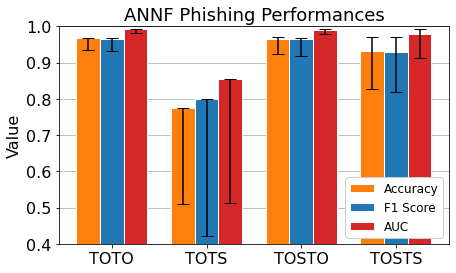

In [49]:
# Bar graph of f1 scores
if plotF1Scores:
    barWidth = 0.25
    
    myEle = modBest
    bars1 = [bestAcc['TOTO'][myEle], bestAcc['TOTS'][myEle], 
             bestAcc['TOSTO'][myEle], bestAcc['TOSTS'][myEle]]
    errs1a = [bestAcc['TOTO'][myEle] - modWorstTOTO, 
              bestAcc['TOTS'][myEle] - modWorstTOTS, 
              bestAcc['TOSTO'][myEle] - modWorstTOSTO, 
              bestAcc['TOSTS'][myEle] - modWorstTOSTS]
    errs1b = [abs(modBestTOTO - bestAcc['TOTO'][myEle]),
              abs(modBestTOTS - bestAcc['TOTS'][myEle]),
              abs(modBestTOSTO - bestAcc['TOSTO'][myEle]),
              abs(modBestTOSTS - bestAcc['TOSTS'][myEle])]
    
    bars2 = [bestF1['TOTO'][myEle], bestF1['TOTS'][myEle], 
             bestF1['TOSTO'][myEle], bestF1['TOSTS'][myEle]]
    errs2a = [bestF1['TOTO'][myEle] - modWorstTOTOF1, 
              bestF1['TOTS'][myEle] - modWorstTOTSF1, 
              bestF1['TOSTO'][myEle] - modWorstTOSTOF1, 
              bestF1['TOSTS'][myEle] - modWorstTOSTSF1]
    errs2b = [abs(modBestTOTOF1 - bestF1['TOTO'][myEle]),
              abs(modBestTOTSF1 - bestF1['TOTS'][myEle]),
              abs(modBestTOSTOF1 - bestF1['TOSTO'][myEle]),
              abs(modBestTOSTSF1 - bestF1['TOSTS'][myEle])]
    
    bars3 = [bestAUC['TOTO'][myEle], bestAUC['TOTS'][myEle], 
             bestAUC['TOSTO'][myEle], bestAUC['TOSTS'][myEle]]
    errs3a = [bestAUC['TOTO'][myEle] - modWorstTOTOAUC, 
              bestAUC['TOTS'][myEle] - modWorstTOTSAUC, 
              bestAUC['TOSTO'][myEle] - modWorstTOSTOAUC, 
              bestAUC['TOSTS'][myEle] - modWorstTOSTSAUC]
    errs3b = [abs(modBestTOTOAUC - bestAUC['TOTO'][myEle]),
              abs(modBestTOTSAUC - bestAUC['TOTS'][myEle]),
              abs(modBestTOSTOAUC - bestAUC['TOSTO'][myEle]),
              abs(modBestTOSTSAUC - bestAUC['TOSTS'][myEle])]

    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    plt.figure(figsize=(7,4))
    ax = plt.axes()        
    ax.yaxis.grid(zorder=0) # horizontal lines

    myCapSize=6
    plt.bar(r1, bars1, yerr=[errs1a,errs1b], capsize=myCapSize,
            color=AllColorsSame[8:12], width=barWidth, edgecolor='white', 
            label='Accuracy', zorder=2)
    plt.bar(r2, bars2, yerr=[errs2a,errs2b], capsize=myCapSize,
            color=AllColorsSame[0:4], width=barWidth, edgecolor='white', 
            label='F1 Score', zorder=2)
    plt.bar(r3, bars3, yerr=[errs3a,errs3b], capsize=myCapSize,
            color=AllColorsSame[4:8], width=barWidth, edgecolor='white', 
            label='AUC', zorder=2)
    
    plt.ylabel('Value')
    plt.ylim([0.4,1.0])
    plt.title('ANNF Phishing Performances')
    plt.xticks([r+barWidth for r in range(len(bars1))], ['TOTO', 'TOTS','TOSTO','TOSTS'])
    plt.legend(fancybox=True, framealpha=1.0, loc='lower right')

    if saveF1Scores:
        plt.savefig(fileF1Scores,bbox_inches='tight',dpi=200)
    else:
        plt.show()

### Feature Sensitivity

In [73]:
plotFeatvAcc = True
saveFeatvAcc = True
fileFeatvAcc = '../figs/FeatvAcc.png'

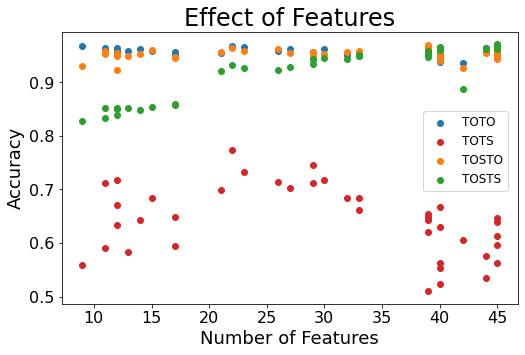

In [74]:
# Plot the number of features versus accuracy
if plotFeatvAcc:
    f = plt.figure(figsize=(18,5))
    ax = f.add_subplot(121)
    ax.set_title('Effect of Features',fontsize=HUGE_SIZE)
    plt.xlabel('Number of Features', fontsize=BIGGER_SIZE)
    plt.ylabel('Accuracy', fontsize=BIGGER_SIZE)
    
    plt.scatter(bestFeat, bestAccTOTO, color=colorTOTO, label='TOTO')
    plt.scatter(bestFeat, bestAccTOTS, color=colorTOTS, label='TOTS')
    plt.scatter(bestFeat, bestAccTOSTO, color=colorTOSTO, label='TOSTO')
    plt.scatter(bestFeat, bestAccTOSTS, color=colorTOSTS, label='TOSTS')
    #plt.scatter(bestFeat, bestAccTOSTOS, color=colorTOSTOS, label='TOSTOS')
    
    #plt.legend(ncol=1, bbox_to_anchor=(1.02, 1.02))
    plt.legend(ncol=1, bbox_to_anchor=(0.99, 0.73))
    
    if saveFeatvAcc:
        plt.savefig(fileFeatvAcc,bbox_inches='tight',dpi=200)
    else:
        plt.show()

### Depth Sensitivity

In [77]:
plotDepthvAcc = True
saveDepthvAcc = True
fileDepthvAcc = '../figs/DepthvAcc.png'

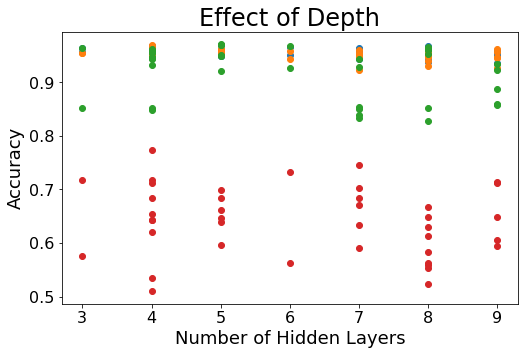

In [78]:
# Plot the number of features versus accuracy
if plotDepthvAcc:
    f = plt.figure(figsize=(18,5))
    ax = f.add_subplot(121)
    ax.set_title('Effect of Depth', fontsize=HUGE_SIZE)
    plt.xlabel('Number of Hidden Layers', fontsize=BIGGER_SIZE)
    plt.ylabel('Accuracy', fontsize=BIGGER_SIZE)
    
    plt.scatter(bestDepth, bestAccTOTO, color=colorTOTO, label='TOTO')
    plt.scatter(bestDepth, bestAccTOTS, color=colorTOTS, label='TOTS')
    plt.scatter(bestDepth, bestAccTOSTO, color=colorTOSTO, label='TOSTO')
    plt.scatter(bestDepth, bestAccTOSTS, color=colorTOSTS, label='TOSTS')
    #plt.scatter(bestDepth, bestAccTOSTOS, color=colorTOSTOS, label='TOSTOS')
    
    #plt.legend(ncol=1, bbox_to_anchor=(1.02, 1.02))
    
    if saveDepthvAcc:
        plt.savefig(fileDepthvAcc,bbox_inches='tight',dpi=200)
    else:
        plt.show()

### Number of Units Sensitivity (per depth layer)

In [88]:
plotUnitsvAcc = True
saveUnitsvAcc = True
fileUnitsvAcc = dirIn + 'figs/UnitsvAcc.png'

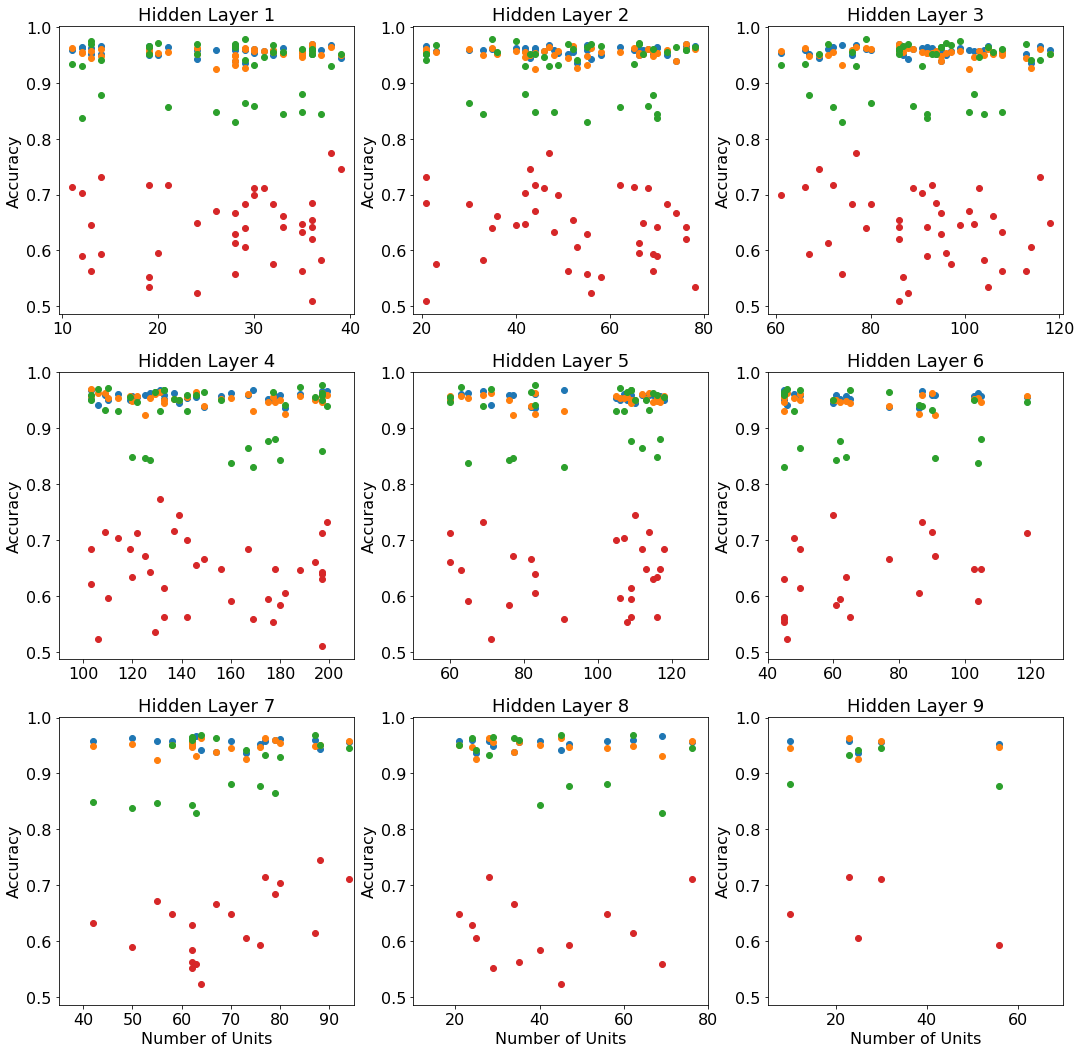

In [89]:
# Plot the number of units per layer versus accuracy
if plotUnitsvAcc:
    minUnits=10
    maxUnits=200
    
    plt.figure(figsize=(18,18))
    plt.subplot(3, 3, 1)
    plt.title('Hidden Layer 1')
    #plt.xlabel('Number of Units')
    #plt.xlim((minUnits,maxUnits))
    plt.ylabel('Accuracy')  
    plt.scatter(bestUnits1, bestAccTOTO, color=colorTOTO, label='TOTO')
    plt.scatter(bestUnits1, bestAccTOTS, color=colorTOTS, label='TOTS')
    plt.scatter(bestUnits1, bestAccTOSTO, color=colorTOSTO, label='TOSTO')
    plt.scatter(bestUnits1, bestAccTOSTS, color=colorTOSTS, label='TOSTS')
    #plt.scatter(bestUnits1, bestAccTOSTOS, color=colorTOSTOS, label='TOSTOS')
    
    plt.subplot(3, 3, 2)
    plt.title('Hidden Layer 2')
    #plt.xlabel('Number of Units')
    plt.ylabel('Accuracy')
    plt.scatter(bestUnits2, bestAccTOTO, color=colorTOTO, label='TOTO')
    plt.scatter(bestUnits2, bestAccTOTS, color=colorTOTS, label='TOTS')
    plt.scatter(bestUnits2, bestAccTOSTO, color=colorTOSTO, label='TOSTO')
    plt.scatter(bestUnits2, bestAccTOSTS, color=colorTOSTS, label='TOSTS')
    #plt.scatter(bestUnits2, bestAccTOSTOS, color=colorTOSTOS, label='TOSTOS')
    
    plt.subplot(3, 3, 3)
    plt.title('Hidden Layer 3')
    #plt.xlabel('Number of Units')
    plt.ylabel('Accuracy')
    plt.scatter(bestUnits3, bestAccTOTO, color=colorTOTO, label='TOTO')
    plt.scatter(bestUnits3, bestAccTOTS, color=colorTOTS, label='TOTS')
    plt.scatter(bestUnits3, bestAccTOSTO, color=colorTOSTO, label='TOSTO')
    plt.scatter(bestUnits3, bestAccTOSTS, color=colorTOSTS, label='TOSTS')
    #plt.scatter(bestUnits3, bestAccTOSTOS, color=colorTOSTOS, label='TOSTOS')
    
    plt.subplot(3, 3, 4)
    plt.title('Hidden Layer 4')
    #plt.xlabel('Number of Units')
    plt.xlim((90,210))
    plt.ylabel('Accuracy')
    plt.scatter(bestUnits4, bestAccTOTO, color=colorTOTO, label='TOTO')
    plt.scatter(bestUnits4, bestAccTOTS, color=colorTOTS, label='TOTS')
    plt.scatter(bestUnits4, bestAccTOSTO, color=colorTOSTO, label='TOSTO')
    plt.scatter(bestUnits4, bestAccTOSTS, color=colorTOSTS, label='TOSTS')
    #plt.scatter(bestUnits4, bestAccTOSTOS, color=colorTOSTOS, label='TOSTOS')
    
    plt.subplot(3, 3, 5)
    plt.title('Hidden Layer 5')
    #plt.xlabel('Number of Units')
    plt.xlim((50,130))
    plt.ylabel('Accuracy')
    plt.scatter(bestUnits5, bestAccTOTO, color=colorTOTO, label='TOTO')
    plt.scatter(bestUnits5, bestAccTOTS, color=colorTOTS, label='TOTS')
    plt.scatter(bestUnits5, bestAccTOSTO, color=colorTOSTO, label='TOSTO')
    plt.scatter(bestUnits5, bestAccTOSTS, color=colorTOSTS, label='TOSTS')
    #plt.scatter(bestUnits5, bestAccTOSTOS, color=colorTOSTOS, label='TOSTOS')
    
    plt.subplot(3, 3, 6)
    plt.title('Hidden Layer 6')
    #plt.xlabel('Number of Units')
    plt.xlim((40,130))
    plt.ylabel('Accuracy')
    plt.scatter(bestUnits6, bestAccTOTO, color=colorTOTO, label='TOTO')
    plt.scatter(bestUnits6, bestAccTOTS, color=colorTOTS, label='TOTS')
    plt.scatter(bestUnits6, bestAccTOSTO, color=colorTOSTO, label='TOSTO')
    plt.scatter(bestUnits6, bestAccTOSTS, color=colorTOSTS, label='TOSTS')
    #plt.scatter(bestUnits6, bestAccTOSTOS, color=colorTOSTOS, label='TOSTOS')
    
    plt.subplot(3, 3, 7)
    plt.title('Hidden Layer 7')
    plt.xlabel('Number of Units')
    plt.xlim((35,95))
    plt.ylabel('Accuracy')
    plt.scatter(bestUnits7, bestAccTOTO, color=colorTOTO, label='TOTO')
    plt.scatter(bestUnits7, bestAccTOTS, color=colorTOTS, label='TOTS')
    plt.scatter(bestUnits7, bestAccTOSTO, color=colorTOSTO, label='TOSTO')
    plt.scatter(bestUnits7, bestAccTOSTS, color=colorTOSTS, label='TOSTS')
    #plt.scatter(bestUnits7, bestAccTOSTOS, color=colorTOSTOS, label='TOSTOS')
    
    plt.subplot(3, 3, 8)
    plt.title('Hidden Layer 8')
    plt.xlabel('Number of Units')
    plt.xlim((10,80))
    plt.ylabel('Accuracy')
    plt.scatter(bestUnits8, bestAccTOTO, color=colorTOTO, label='TOTO')
    plt.scatter(bestUnits8, bestAccTOTS, color=colorTOTS, label='TOTS')
    plt.scatter(bestUnits8, bestAccTOSTO, color=colorTOSTO, label='TOSTO')
    plt.scatter(bestUnits8, bestAccTOSTS, color=colorTOSTS, label='TOSTS')
    #plt.scatter(bestUnits8, bestAccTOSTOS, color=colorTOSTOS, label='TOSTOS')
    
    plt.subplot(3, 3, 9)
    plt.title('Hidden Layer 9')
    plt.xlabel('Number of Units')
    plt.xlim((5,70))
    plt.ylabel('Accuracy')
    plt.scatter(bestUnits9, bestAccTOTO, color=colorTOTO, label='TOTO')
    plt.scatter(bestUnits9, bestAccTOTS, color=colorTOTS, label='TOTS')
    plt.scatter(bestUnits9, bestAccTOSTO, color=colorTOSTO, label='TOSTO')
    plt.scatter(bestUnits9, bestAccTOSTS, color=colorTOSTS, label='TOSTS')
    #plt.scatter(bestUnits9, bestAccTOSTOS, color=colorTOSTOS, label='TOSTOS')
    
    #plt.legend(ncol=1, bbox_to_anchor=(1.02, 1.02))
    
    if saveUnitsvAcc:
        plt.savefig(fileUnitsvAcc,bbox_inches='tight',dpi=200)
    else:
        plt.show()

### Epoch Sensitivity

In [91]:
plotEpochsvAcc = True
saveEpochsvAcc = True
fileEpochsvAcc = dirIn + 'figs/EpochsvAcc.png'

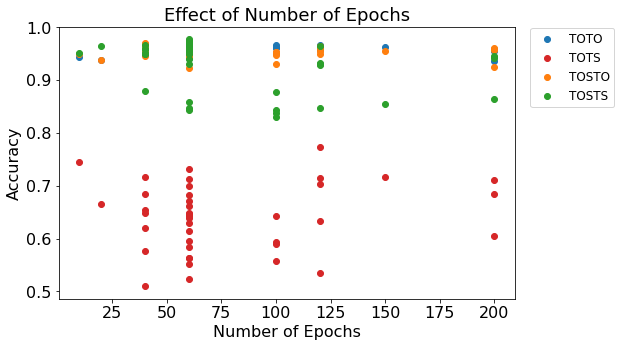

In [93]:
# Plot the number of features versus accuracy
if plotEpochsvAcc:
    f = plt.figure(figsize=(18,5))
    ax = f.add_subplot(121)
    ax.set_title('Effect of Number of Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    
    plt.scatter(bestEpochs, bestAccTOTO, color=colorTOTO, label='TOTO')
    plt.scatter(bestEpochs, bestAccTOTS, color=colorTOTS, label='TOTS')
    plt.scatter(bestEpochs, bestAccTOSTO, color=colorTOSTO, label='TOSTO')
    plt.scatter(bestEpochs, bestAccTOSTS, color=colorTOSTS, label='TOSTS')
    #plt.scatter(bestEpochs, bestAccTOSTOS, color=colorTOSTOS, label='TOSTOS')
    
    plt.legend(ncol=1, bbox_to_anchor=(1.02, 1.02))
    
    if saveEpochsvAcc:
        plt.savefig(fileEpochsvAcc,bbox_inches='tight',dpi=200)
    else:
        plt.show()

### Effects of Epochs and Hidden Layers

In [68]:
plotEHA = True
saveEHA = True
fileEHA = dirIn + 'figs/EpochsvLayers.png'

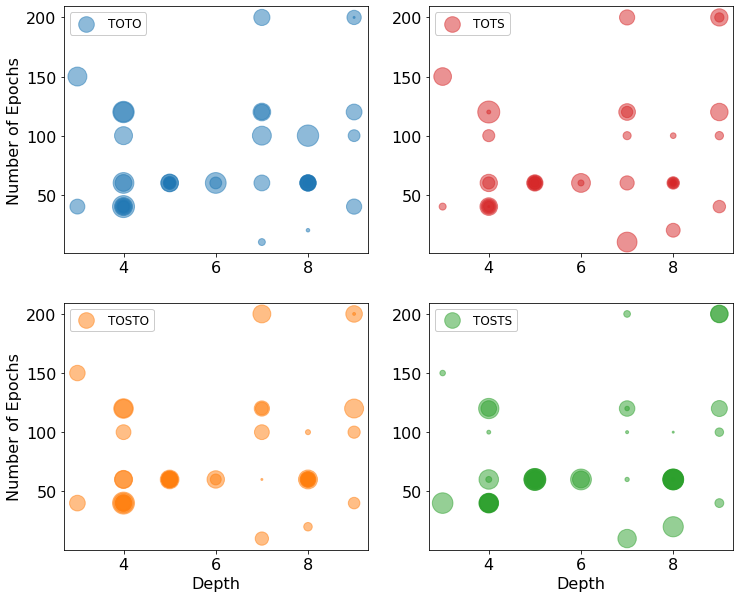

In [69]:
# Plot the epochs versus hidden layers, size being accuracy
if plotEHA:
  
    scaleFactor = 400
    alpha = 0.5

    plt.subplot(2, 2, 1)
    minA = np.min(bestAccTOTO)
    maxA = np.max(bestAccTOTO)
    diffA = maxA-minA
    normTOTO = (bestAccTOTO - minA)/(diffA)+0.1
    area = normTOTO*normTOTO*scaleFactor
    plt.scatter(bestDepth, bestEpochs, s=area, color=colorTOTO, 
                label='TOTO', alpha=alpha)
    plt.legend(fancybox=True, framealpha=1.0, loc='upper left')
    plt.title = 'TOTO'
    plt.ylabel('Number of Epochs')

    plt.subplot(2, 2, 2)
    plt.title = 'TOTS'
    minA = np.min(bestAccTOTS)
    maxA = np.max(bestAccTOTS)
    diffA = maxA-minA
    normTOTS = (bestAccTOTS - minA)/(diffA)+0.1
    area = normTOTS*normTOTS*scaleFactor
    plt.scatter(bestDepth, bestEpochs, s=area, color=colorTOTS, 
                label='TOTS', alpha=alpha)
    plt.legend(fancybox=True, framealpha=1.0, loc='upper left')
    
    plt.subplot(2, 2, 3)
    plt.title = 'TOSTO'
    plt.ylabel('Number of Epochs')
    plt.xlabel('Depth')
    minA = np.min(bestAccTOSTO)
    maxA = np.max(bestAccTOSTO)
    diffA = maxA-minA
    normTOSTO = (bestAccTOSTO - minA)/(diffA)+0.1
    area = normTOSTO*normTOSTO*scaleFactor
    plt.scatter(bestDepth, bestEpochs, s=area, color=colorTOSTO, 
                label='TOSTO', alpha=alpha)
    plt.legend(fancybox=True, framealpha=1.0, loc='upper left')
    
    plt.subplot(2, 2, 4)
    plt.title = 'TOSTS'
    plt.xlabel('Depth')
    minA = np.min(bestAccTOSTS)
    maxA = np.max(bestAccTOSTS)
    diffA = maxA-minA
    normTOSTS = (bestAccTOSTS - minA)/(diffA)+0.1
    area = normTOSTS*normTOSTS*scaleFactor
    plt.scatter(bestDepth, bestEpochs, s=area, color=colorTOSTS, 
                label='TOSTS', alpha=alpha)
    plt.legend(fancybox=True, framealpha=1.0, loc='upper left')
    
    if saveEHA:
        plt.savefig(fileEHA,bbox_inches='tight',dpi=200)
    else:
        plt.show()

### Decrease and Recovery

In [56]:
plotDR = True
saveDR = True
fileDR = dirIn + 'figs/DecreaseRecovery.png'

plotDRDiff = True
saveDRDiff = True
fileDRDiff = dirIn + 'figs/DecreaseRecoveryDiff.png'

In [57]:
# Create necessary information
if plotDR or plotDRDiff:
    decreaseF1 = np.zeros(nTries)
    recoverF1 = np.zeros(nTries)
    decreaseAcc = np.zeros(nTries)
    recoverAcc = np.zeros(nTries)
    decreaseAUC = np.zeros(nTries)
    recoverAUC = np.zeros(nTries)
    
    minDF1 = 0.
    maxDF1 = -1.
    minRF1 = 1.
    maxRF1 = -1.
    minDAcc = 0.
    maxDAcc = -1.
    minRAcc = 1.
    maxRAcc = -1.
    minDAUC = 0.
    maxDAUC = -1.
    minRAUC = 1.
    maxRAUC = -1.
    for i in range(nTries):
        decreaseF1[i] = bestF1['TOTS'][i] - bestF1['TOTO'][i]
        if decreaseF1[i] < minDF1:
            minDF1 = decreaseF1[i]
        if decreaseF1[i] > maxDF1:
            maxDF1 = decreaseF1[i]
            
        recoverF1[i] = bestF1['TOSTO'][i] - bestF1['TOTS'][i]
        if recoverF1[i] < minRF1:
            minRF1 = recoverF1[i]
        if recoverF1[i] > maxRF1:
            maxRF1 = recoverF1[i]
            
        decreaseAcc[i] = bestAcc['TOTS'][i] - bestAcc['TOTO'][i]
        if decreaseAcc[i] < minDAcc:
            minDAcc = decreaseAcc[i]
        if decreaseAcc[i] > maxDAcc:
            maxDAcc = decreaseAcc[i]
            
        recoverAcc[i] = bestAcc['TOSTO'][i] - bestAcc['TOTS'][i]
        if recoverAcc[i] < minRAcc:
            minRAcc = recoverAcc[i]
        if recoverAcc[i] > maxRAcc:
            maxRAcc = recoverAcc[i]
            
        decreaseAUC[i] = bestAUC['TOTS'][i] - bestAUC['TOTO'][i]
        if decreaseAUC[i] < minDAUC:
            minDAUC = decreaseAUC[i]
        if decreaseAUC[i] > maxDAUC:
            maxDAUC = decreaseAUC[i]
            
        recoverAUC[i] = bestAUC['TOSTO'][i] - bestAUC['TOTS'][i]
        if recoverAUC[i] < minRAUC:
            minRAUC = recoverAUC[i]
        if recoverAUC[i] > maxRAUC:
            maxRAUC = recoverAUC[i]
        
    meanDF1 = np.mean(decreaseF1)
    meanRF1 = np.mean(recoverF1)
    meanDAcc = np.mean(decreaseAcc)
    meanRAcc = np.mean(recoverAcc)
    meanDAUC = np.mean(decreaseAUC)
    meanRAUC = np.mean(recoverAUC)

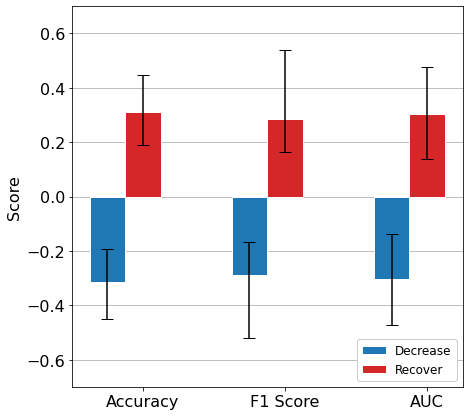

In [58]:
# Create decrease/recovery bar graph
if plotDR:
    # Create bar graph
    barWidth = 0.25
    bars1 = [meanDAcc, meanDF1, meanDAUC]
    errs1a = [meanDAcc - minDAcc, meanDF1 - minDF1, meanDAUC - minDAUC]
    errs1b = [maxDAcc - meanDAcc, maxDF1 - meanDF1, maxDAUC-meanDAUC]
    
    bars2 = [meanRAcc, meanRF1, meanRAUC]
    errs2a = [meanRAcc-minRAcc, meanRF1 - minRF1, meanRAUC-minRAUC]
    errs2b = [maxRAcc-meanRAcc,maxRF1-meanRF1,maxRAUC-meanRAUC]
    
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    
    plt.figure(figsize=(7,7))
    ax = plt.axes()  
    ax.yaxis.grid(zorder=0) # horizontal lines

    myCapSize=6
    plt.bar(r1, bars1, yerr=[errs1a,errs1b], capsize=myCapSize,
            color='tab:blue', width=barWidth, edgecolor='white', 
            label='Decrease', zorder=2)
    plt.bar(r2, bars2, yerr=[errs2a,errs2b], capsize=myCapSize,
            color='tab:red', width=barWidth, edgecolor='white', 
            label='Recover', zorder=2)
    plt.ylim((-.7,.7))
    
    plt.ylabel('Score')
    plt.xticks([r+barWidth for r in range(len(bars1))], ['Accuracy', 'F1 Score','AUC'])
    plt.legend(fancybox=True, framealpha=1.0, loc='lower right')

    if saveDR:
        plt.savefig(fileDR,bbox_inches='tight',dpi=200)
    else:
        plt.show()

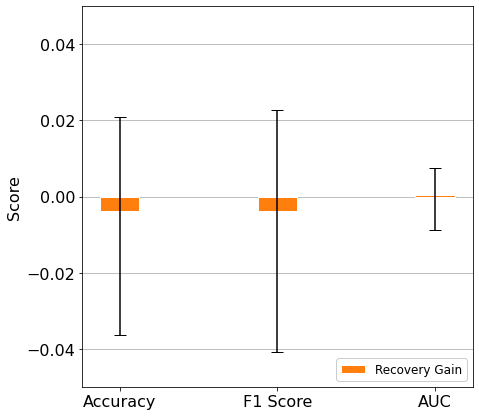

In [79]:
# Create recovery gain graph
if plotDRDiff:
    diffAcc = np.zeros(nTries)
    diffF1 = np.zeros(nTries)
    diffAUC = np.zeros(nTries)
    
    minDiffF1 = 0.
    maxDiffF1 = -1.
    minDiffAcc = 0.
    maxDiffAcc = -1.
    minDiffAUC = 0.
    maxDiffAUC = -1.
    for i in range(nTries):
        diffAcc[i] = decreaseAcc[i] + recoverAcc[i]
        diffF1[i] = decreaseF1[i] + recoverF1[i]
        diffAUC[i] = decreaseAUC[i] + recoverAUC[i]
        
        if diffAcc[i] < minDiffAcc:
            minDiffAcc = diffAcc[i]
        if diffAcc[i] > maxDiffAcc:
            maxDiffAcc = diffAcc[i]
            
        if diffF1[i] < minDiffF1:
            minDiffF1 = diffF1[i]
        if diffF1[i] > maxDiffF1:
            maxDiffF1 = diffF1[i]
            
        if diffAUC[i] < minDiffAUC:
            minDiffAUC = diffAUC[i]
        if diffAUC[i] > maxDiffAUC:
            maxDiffAUC = diffAUC[i]
        
    meanDiffAcc = np.mean(diffAcc)
    meanDiffF1 = np.mean(diffF1)
    meanDiffAUC = np.mean(diffAUC)
    
    # Create bar graph
    barWidth = 0.25
    bars1 = [meanDiffAcc, meanDiffF1, meanDiffAUC]
    errs1a = [meanDiffAcc - minDiffAcc, meanDiffF1 - minDiffF1, 
              meanDiffAUC - minDiffAUC]
    errs1b = [maxDiffAcc - meanDiffAcc, maxDiffF1 - meanDiffF1, 
              maxDiffAUC-meanDiffAUC]

    r1 = np.arange(len(bars1))
    
    plt.figure(figsize=(7,7))
    ax = plt.axes()  
    ax.yaxis.grid(zorder=0) # horizontal lines

    myCapSize=6
    plt.bar(r1, bars1, yerr=[errs1a,errs1b], capsize=myCapSize,
            color='tab:orange', width=barWidth, edgecolor='white', 
            label='Recovery Gain', zorder=2)

    plt.ylim((-.05,.05))
    
    plt.ylabel('Score')
    plt.xticks([r for r in range(len(bars1))], ['Accuracy', 'F1 Score','AUC'])
    plt.legend(fancybox=True, framealpha=1.0, loc='lower right')

    if saveDRDiff:
        plt.savefig(fileDRDiff,bbox_inches='tight',dpi=200)
    else:
        plt.show()

### Confusion Matrix

In [36]:
plotConfMatrix = True
saveConfMatrix = False
fileConfMatrix = dirIn + 'figs/ConfusionMatrixSynTOTO.png'

fileConfParams = './saveSynNN/TestResults40.pkl'

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 35)                1645      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                1656      
_________________________________________________________________
dropout (Dropout)            (None, 46)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 114)               5358      
_________________________________________________________________
dropout_1 (Dropout)          (None, 114)               0         
_________________________________________________________________
dense_3 (Dens

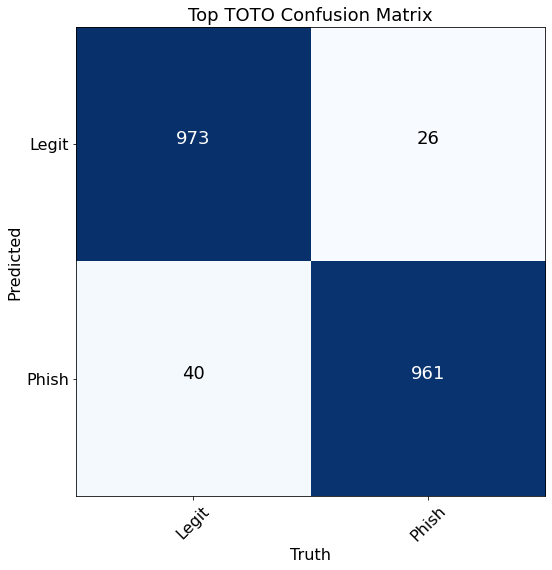

In [41]:
if plotConfMatrix:
    with open(fileConfParams, 'rb') as handle:
        allTemp = pickle.load(handle)
    topAcc = allTemp[0]
    topCV = allTemp[1]
    topTest = allTemp[2]
    topParams = allTemp[3]
    
    if not saveConfMatrix:
        fileConfMatrix = ''
    TestResults, TestHistory, TestPredict = \
             test_model(topParams[0], 
                        XTrain, YTrain,
                        XTest, YTest, verbose=True,
                        YPrint=True, YConf=True, 
                        YConfTitle='Top TOTO Confusion Matrix', 
                        YConfSave=fileConfMatrix)

### M1 versus M2

In [50]:
plotComparison = True
saveComparison = True
fileComparison = dirIn + 'figsSyn/ModCompN.png'

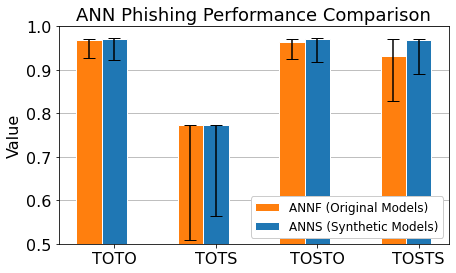

In [81]:
# Create ANNF versus ANNS Plot
if plotComparison:
    barWidth = 0.25
    bars1 = [0.9695, 0.774, 0.9645, 0.9319999814033508]
    errs1a = [0.043, 0.26449996, 0.040499985, 0.10449999570846558]
    errs1b = [0.0019999743, 0.0, 0.0055000186, 0.03900003433227539]
    
    bars2 = [0.9714999794960022, 0.7739999890327454, 0.9714999794960022, 0.968500018119812]
    errs2a = [0.04799997806549072, 0.20899999141693115,
              0.05449998378753662, 0.07750004529953003]
    errs2b = [0.0015000104904174805, 0.0, 0.002499997615814209, 0.0034999847412109375]
    
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    
    plt.figure(figsize=(7,4))
    ax = plt.axes()        
    ax.yaxis.grid(zorder=0) # horizontal lines

    myCapSize=6
    plt.bar(r1, bars1, yerr=[errs1a,errs1b], capsize=myCapSize,
            color=AllColorsSame[8:12], width=barWidth, edgecolor='white', 
            label='ANNF (Original Models)', zorder=2)
    plt.bar(r2, bars2, yerr=[errs2a,errs2b], capsize=myCapSize,
            color=AllColorsSame[0:4], width=barWidth, edgecolor='white', 
            label='ANNS (Synthetic Models)', zorder=2)
    
    plt.ylabel('Value')
    plt.ylim([0.5,1.])
    plt.title('ANN Phishing Performance Comparison')
    plt.xticks([r+barWidth for r in range(len(bars1))], ['TOTO', 'TOTS','TOSTO','TOSTS'])
    plt.legend(fancybox=True, framealpha=1.0, loc='lower right')

    if saveComparison:
        plt.savefig(fileComparison,bbox_inches='tight',dpi=200)
    else:
        plt.show()